In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import random
import itertools

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import sys
sys.path.append('/data/Hydra_Work/Competition_Functions') 
from Processing_Functions import process_forecast_date, process_seasonal_forecasts
from Data_Transforming import read_nested_csvs, generate_daily_flow, use_USGS_flow_data, USGS_to_daily_df_yearly
from Full_LSTM_ML_Functions import SumPinballLoss


sys.path.append('/data/Hydra_Work/Pipeline_Functions')
from Folder_Work import filter_rows_by_year, csv_dictionary, add_day_of_year_column


from datetime import datetime
import torch
import torch.nn as nn


In [ ]:
# All the prep
monthly_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',
    'fontenelle_reservoir_inflow', 'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow',
    'missouri_r_at_toston','owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',
    'ruedi_reservoir_inflow', 'skagit_ross_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin', 'sweetwater_r_nr_alcova',
    'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]


USGS_basins = ['animas_r_at_durango', 'boise_r_nr_boise', 'boysen_reservoir_inflow', 'colville_r_at_kettle_falls', 'detroit_lake_inflow', 'dillon_reservoir_inflow',   
    'green_r_bl_howard_a_hanson_dam', 'hungry_horse_reservoir_inflow', 'libby_reservoir_inflow', 'merced_river_yosemite_at_pohono_bridge', 'missouri_r_at_toston',
    'owyhee_r_bl_owyhee_dam', 'pecos_r_nr_pecos', 'pueblo_reservoir_inflow',    'san_joaquin_river_millerton_reservoir', 'snake_r_nr_heise', 'stehekin_r_at_stehekin',
    'sweetwater_r_nr_alcova', 'taylor_park_reservoir_inflow', 'virgin_r_at_virtin', 'weber_r_nr_oakley', 'yampa_r_nr_maybell',
]

basins = list(set(monthly_basins + USGS_basins))


selected_years = range(2000,2024,2)

era5_folder = '/data/Hydra_Work/Rodeo_Data/era5'
era5 = csv_dictionary(era5_folder, basins, years=selected_years)
era5 = add_day_of_year_column(era5)

flow_folder = '/data/Hydra_Work/Rodeo_Data/train_monthly_naturalized_flow'
flow = csv_dictionary(flow_folder, monthly_basins)
flow = filter_rows_by_year(flow, 1998)

climatology_file_path = '/data/Hydra_Work/Rodeo_Data/climate_indices.csv'
climate_indices = pd.read_csv(climatology_file_path)
climate_indices['date'] = pd.to_datetime(climate_indices['date'])
climate_indices.set_index('date', inplace = True)
climate_indices.drop('Unnamed: 0', axis = 1, inplace = True)
climate_indices = climate_indices[~climate_indices.index.duplicated(keep='first')]

root_folder = '/data/Hydra_Work/Rodeo_Data/seasonal_forecasts'
seasonal_forecasts = read_nested_csvs(root_folder)

USGS_flow_folder = '/data/Hydra_Work/Rodeo_Data/USGS_streamflows'
USGS_flow = csv_dictionary(USGS_flow_folder, USGS_basins)

Static_variables = pd.read_csv('/data/Hydra_Work/Rodeo_Data/static_indices.csv', index_col= 'site_id')

# Convert monthly flow values to daily flow estimates
daily_flow = {}

# Iterate through the dictionary and apply generate_daily_flow to each DataFrame
for key, df in flow.items():
    daily_flow[key] = generate_daily_flow(df, persistence_factor=0.7)

# Replacing monhtly data for normalised USGS when available
daily_flow = use_USGS_flow_data(daily_flow, USGS_flow)

# Need to only do basins which have daily flow if we want to train this model for weekly
normalising_basins = ['san_joaquin_river_millerton_reservoir', 'merced_river_yosemite_at_pohono_bridge', 'detroit_lake_inflow']
for basin in normalising_basins:
    path = f'/data/Hydra_Work/Rodeo_Data/USGS_streamflows/{basin}.csv' 
    normalising_path = f'/data/Hydra_Work/Rodeo_Data/train_yearly/{basin}.csv'
    USGS_to_daily_df_yearly(daily_flow, path, basin, normalising_path)

climate_scaler_filename = '/data/Hydra_Work/Rodeo_Data/scalers/climate_normalization_scaler.save'
climate_scaler = joblib.load(climate_scaler_filename) 
climate_indices = pd.DataFrame(climate_scaler.transform(climate_indices), columns=climate_indices.columns, index=climate_indices.index)

era5_scaler_filename = '/data/Hydra_Work/Rodeo_Data/scalers/era5_scaler.save'
era5_scaler = joblib.load(era5_scaler_filename) 
era5 = {key: pd.DataFrame(era5_scaler.transform(df), columns=df.columns, index=df.index) for key, df in era5.items()}

for basin, df in daily_flow.items(): 
    flow_scaler_filename = f'/data/Hydra_Work/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save'
    flow_scaler = joblib.load(flow_scaler_filename) 
    daily_flow[basin] = pd.DataFrame(flow_scaler.transform(df), columns=df.columns, index=df.index)

seasonal_scaler_filename = "/data/Hydra_Work/Rodeo_Data/scalers/seasonal_scaler.save"
seasonal_scaler = joblib.load(seasonal_scaler_filename)
seasonal_forecasts = {key: pd.DataFrame(seasonal_scaler.transform(df), columns=df.columns, index=df.index ) for key, df in seasonal_forecasts.items()}

static_scaler_filename = '/data/Hydra_Work/Rodeo_Data/scalers/static_scaler.save'
static_scaler = joblib.load(static_scaler_filename) 
static_variables = pd.DataFrame(static_scaler.transform(Static_variables), columns=Static_variables.columns, index=Static_variables.index)

climatological_flows = {}

for basin, df in daily_flow.items():
    # Extract day of year and flow values
    df['day_of_year'] = df.index.dayofyear

    grouped = df.groupby('day_of_year')['daily_flow'].quantile([0.1, 0.5, 0.9]).unstack(level=1)

    climatological_flows[basin] = pd.DataFrame({
        'day_of_year': grouped.index,
        '10th_percentile_flow': grouped[0.1],
        '50th_percentile_flow': grouped[0.5],
        '90th_percentile_flow': grouped[0.9]
    })
    
    climatological_flows[basin].set_index('day_of_year', inplace=True)

    # Drop the temporary 'day_of_year' column from the original dataframe
    df.drop(columns='day_of_year', inplace=True)

criterion = SumPinballLoss(quantiles = [0.1, 0.5, 0.9])

basin = 'animas_r_at_durango' 
All_Dates = daily_flow[basin].index[
    ((daily_flow[basin].index.month < 6) | ((daily_flow[basin].index.month == 6) & (daily_flow[basin].index.day < 24))) &
    ((daily_flow[basin].index.year % 2 == 0) | ((daily_flow[basin].index.month > 10) | ((daily_flow[basin].index.month == 10) & (daily_flow[basin].index.day >= 1))))
]
All_Dates = All_Dates[All_Dates.year > 1998]


# Validation Year
Val_Dates = All_Dates[All_Dates.year >= 2020]
All_Dates = All_Dates[All_Dates.year < 2020]


basin_to_remove = 'sweetwater_r_nr_alcova'

if basin_to_remove in basins:
    basins.remove(basin_to_remove)


seed = 42 ; torch.manual_seed(seed) ; random.seed(seed) ; np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

days  = 90
hindcast_input_size = 17

LR = 1e-3
static_size = np.shape(Static_variables)[1]
forecast_size = np.shape(seasonal_forecasts['american_river_folsom_lake_2000_apr'])[1]
History_Fourier_in_forcings = 0 #2*3*(6 - 1)
Climate_guess = 3
History_Statistics_in_forcings = 5*2

head_input_size = forecast_size + static_size + History_Fourier_in_forcings + History_Statistics_in_forcings  + Climate_guess + 3
head_output_size = 3

# Only include daily flow basins
basin = list(set(basins) - set(['ruedi_reservoir_inflow', 'skagit_ross_reservoir']))




In [ ]:
# Load All the Models
General_LSTM_Model = torch.load('/data/Hydra_Work/Tuning/Week_Ahead_Models/General_LSTM.pth')
Hydra_General_Head = torch.load('/data/Hydra_Work/Tuning/Week_Ahead_Models/Hydra_Head_LSTM.pth')
Hydra_Body = torch.load('/data/Hydra_Work/Tuning/Week_Ahead_Models/Hydra_Body_LSTM.pth')
Specific_Heads = {}
Specific_Models = {}
for basin in basins:
    Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/Tuning/Week_Ahead_Models/Hydra_Heads/{basin}.path')
    Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/Tuning/Week_Ahead_Models/Specific_Week_Ahead_Models/{basin}_specific.pth')

# Evaluation Plots

In [ ]:
import joblib
import sys
sys.path.append('/data/Hydra_Work/Performance_Evaluation') 
from Evaluation_Functions import test_weekly_performance, test_weekly_performance_hydra



In [ ]:
feed_forcing = False
year = 2022
years = np.arange(2000,2024,2)
start_season_date = f'{year}-01-01' 
end_season_date = f'{year}-06-26'
basin = 'san_joaquin_river_millerton_reservoir'
daily_flow['san_joaquin_river_millerton_reservoir']


Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
_, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
_, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)

In [ ]:
Days = len(Basin_Head_Guesses)
Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)

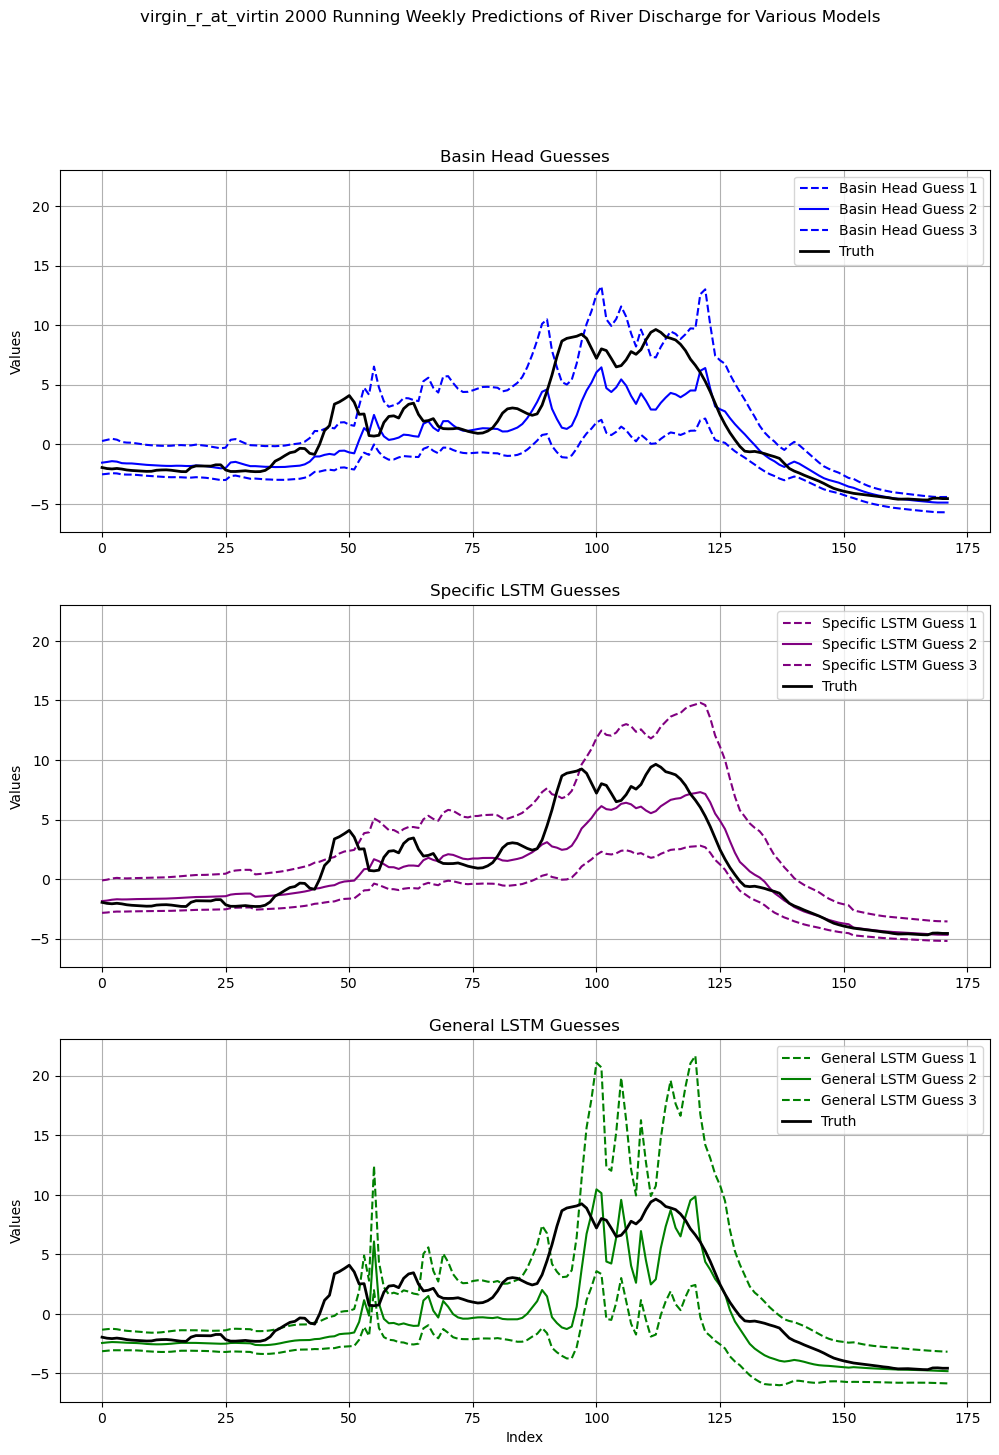

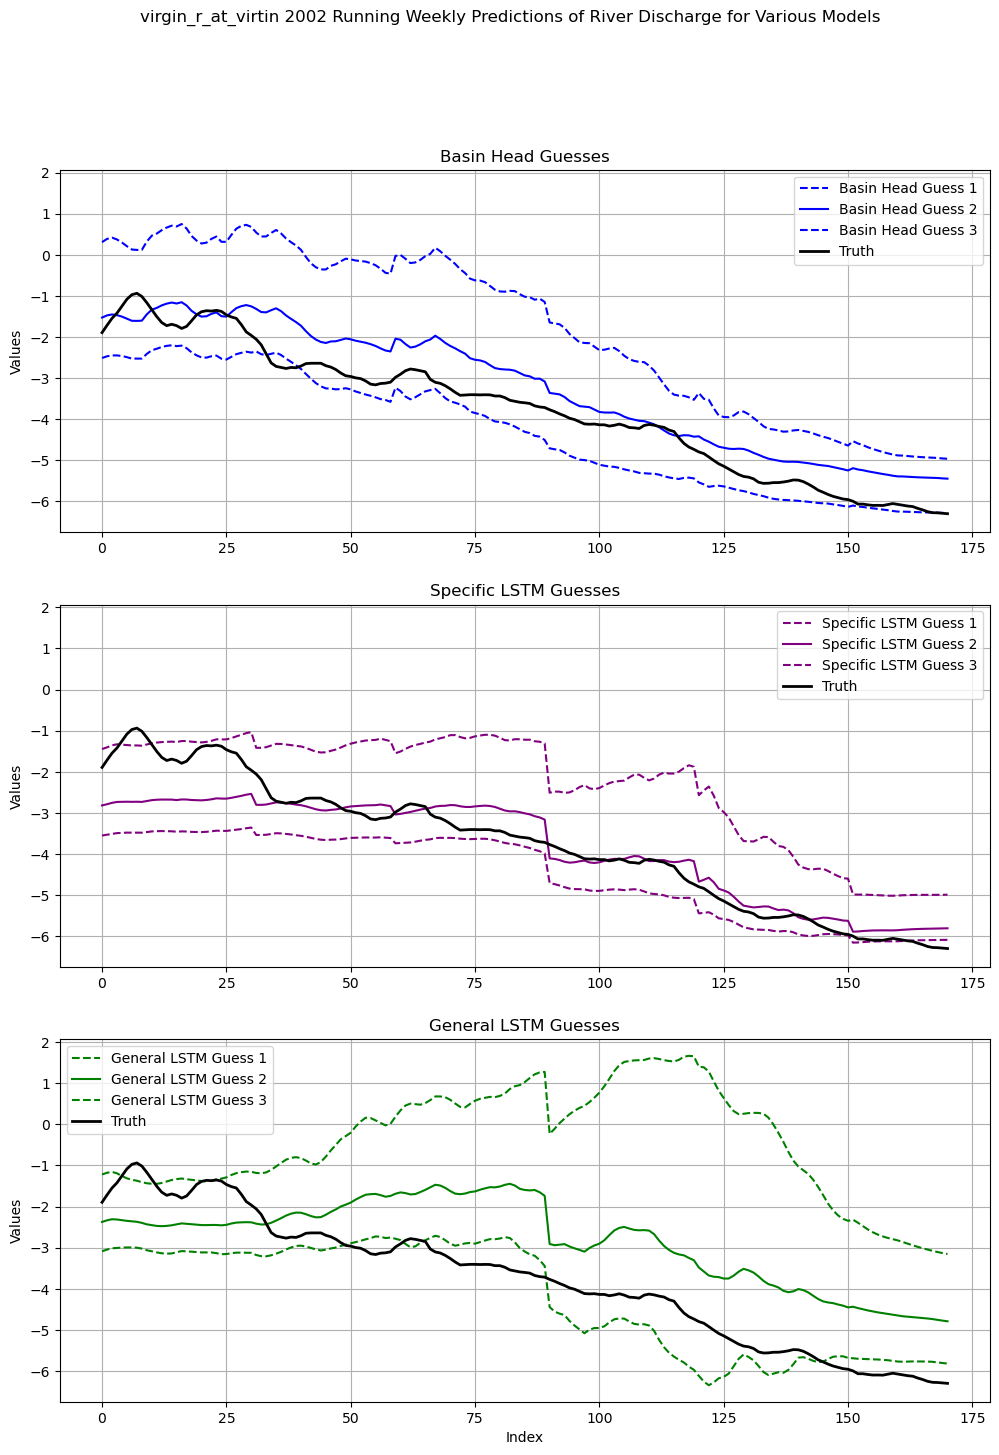

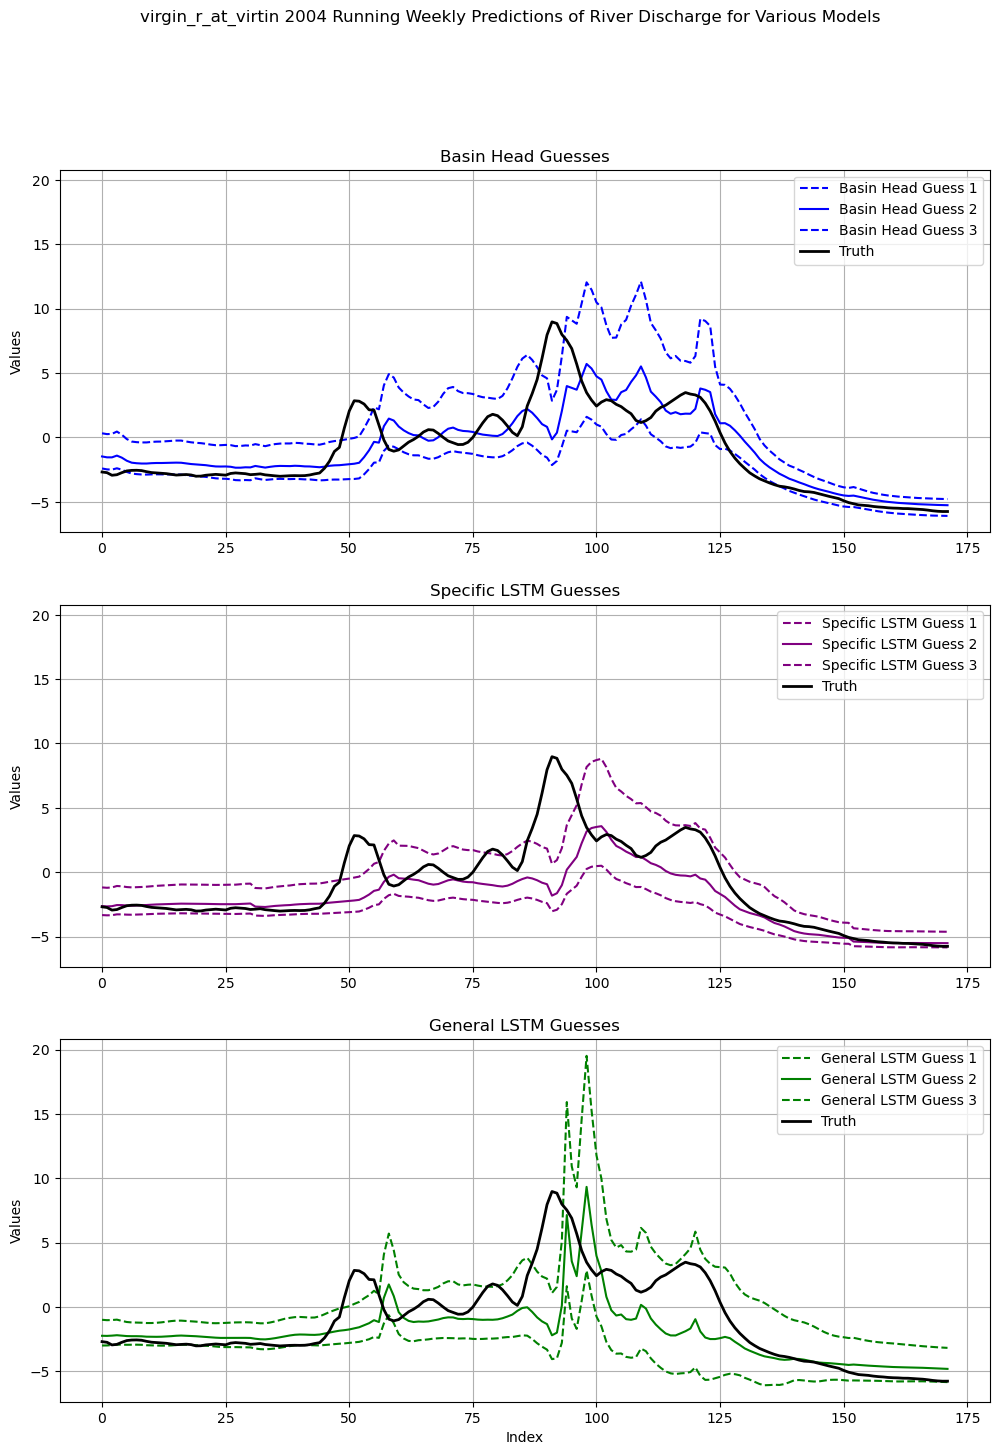

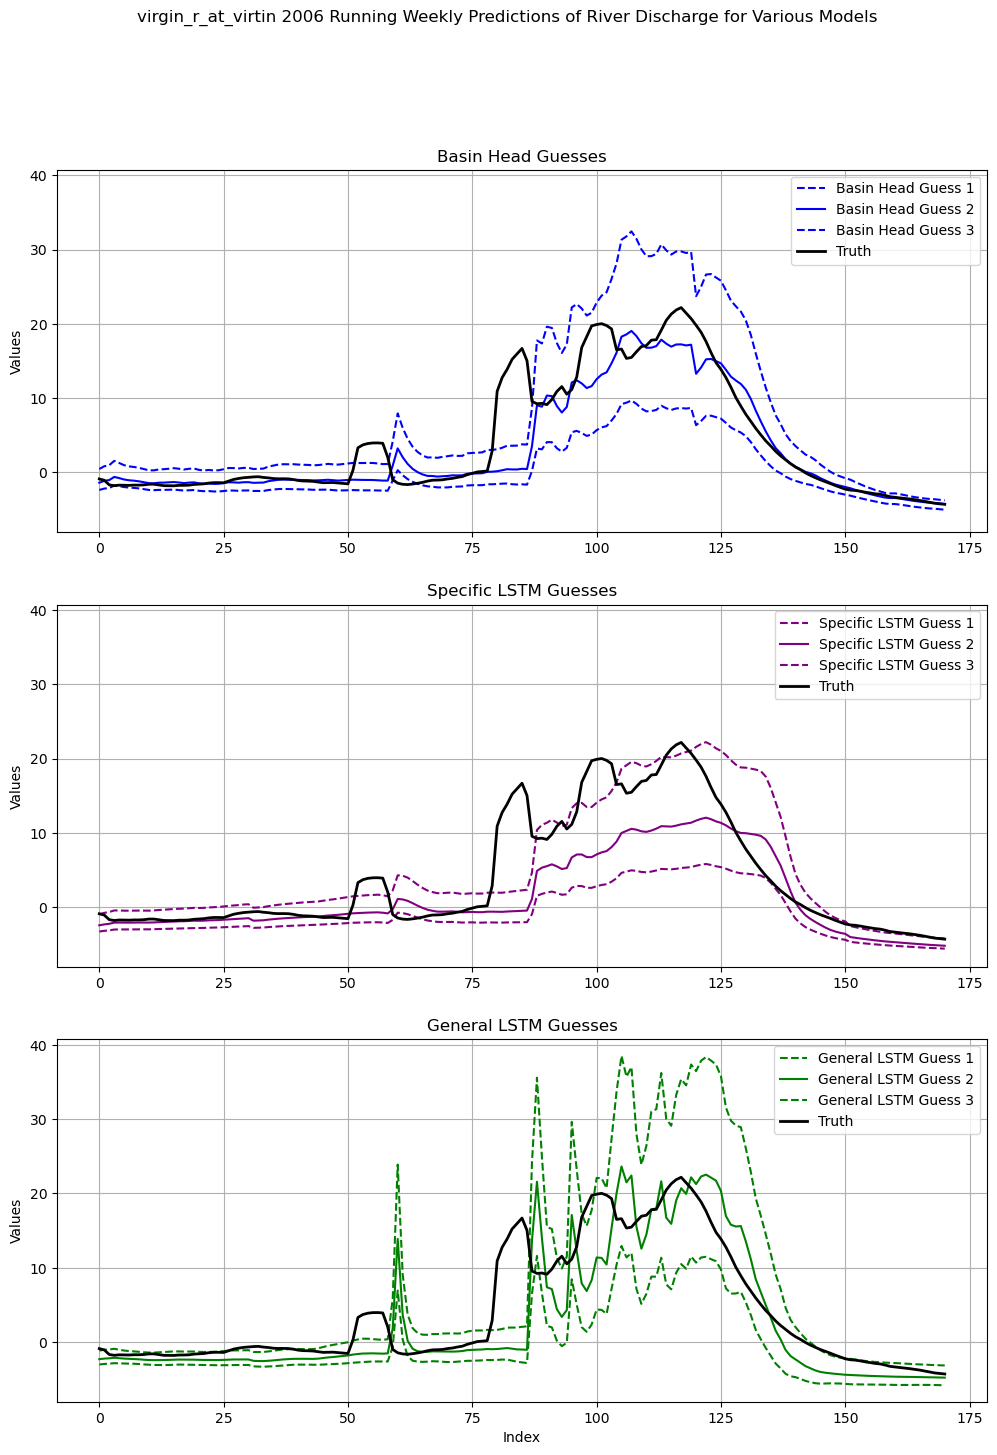

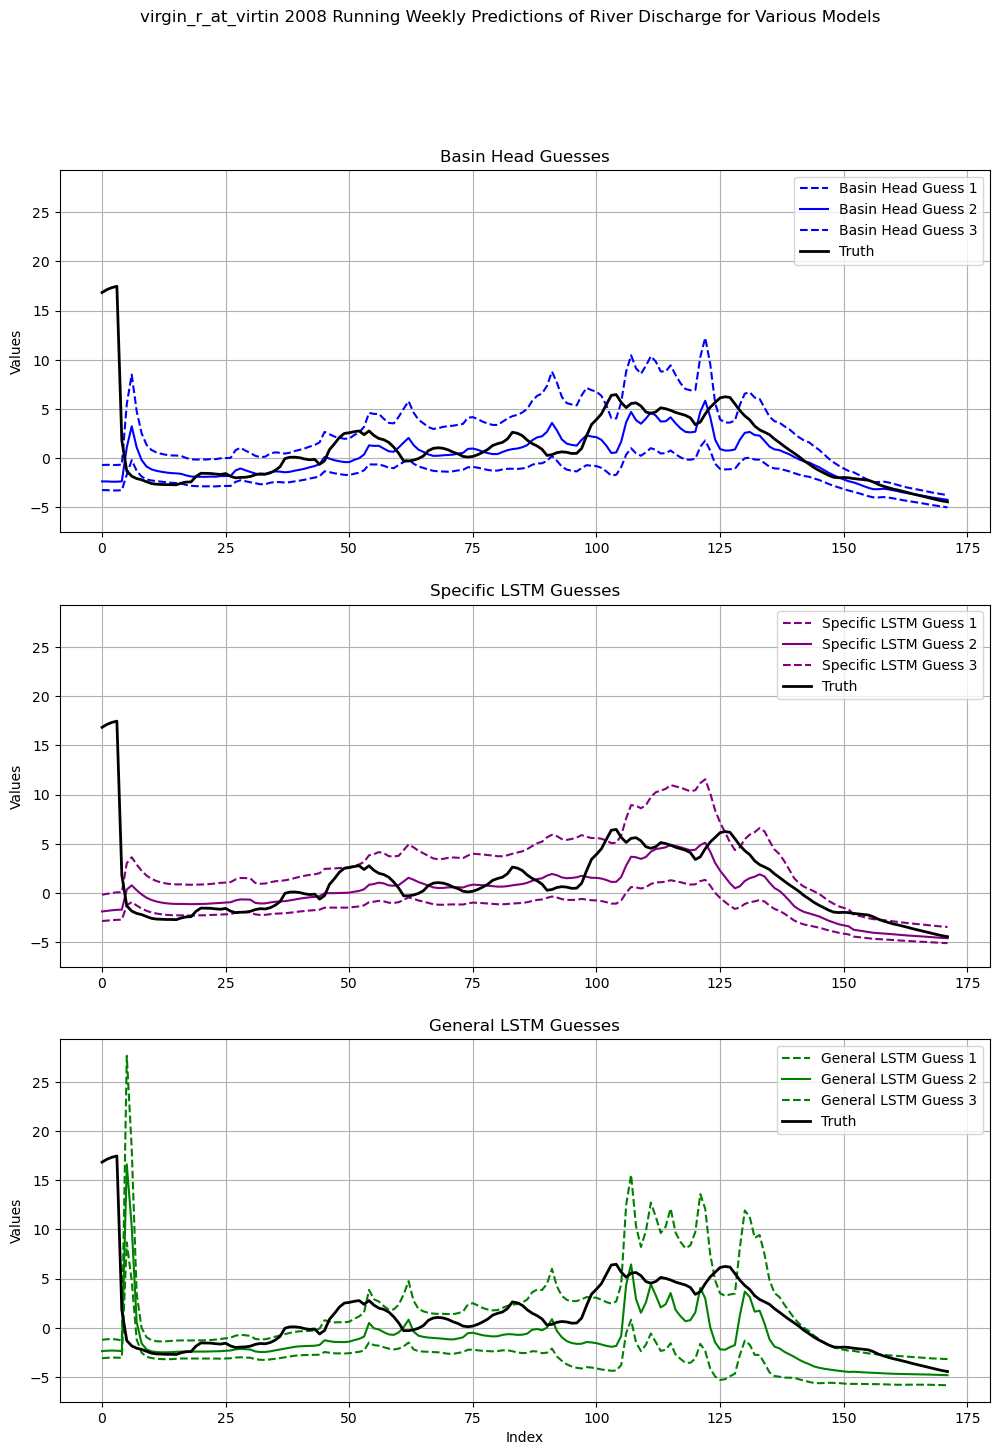

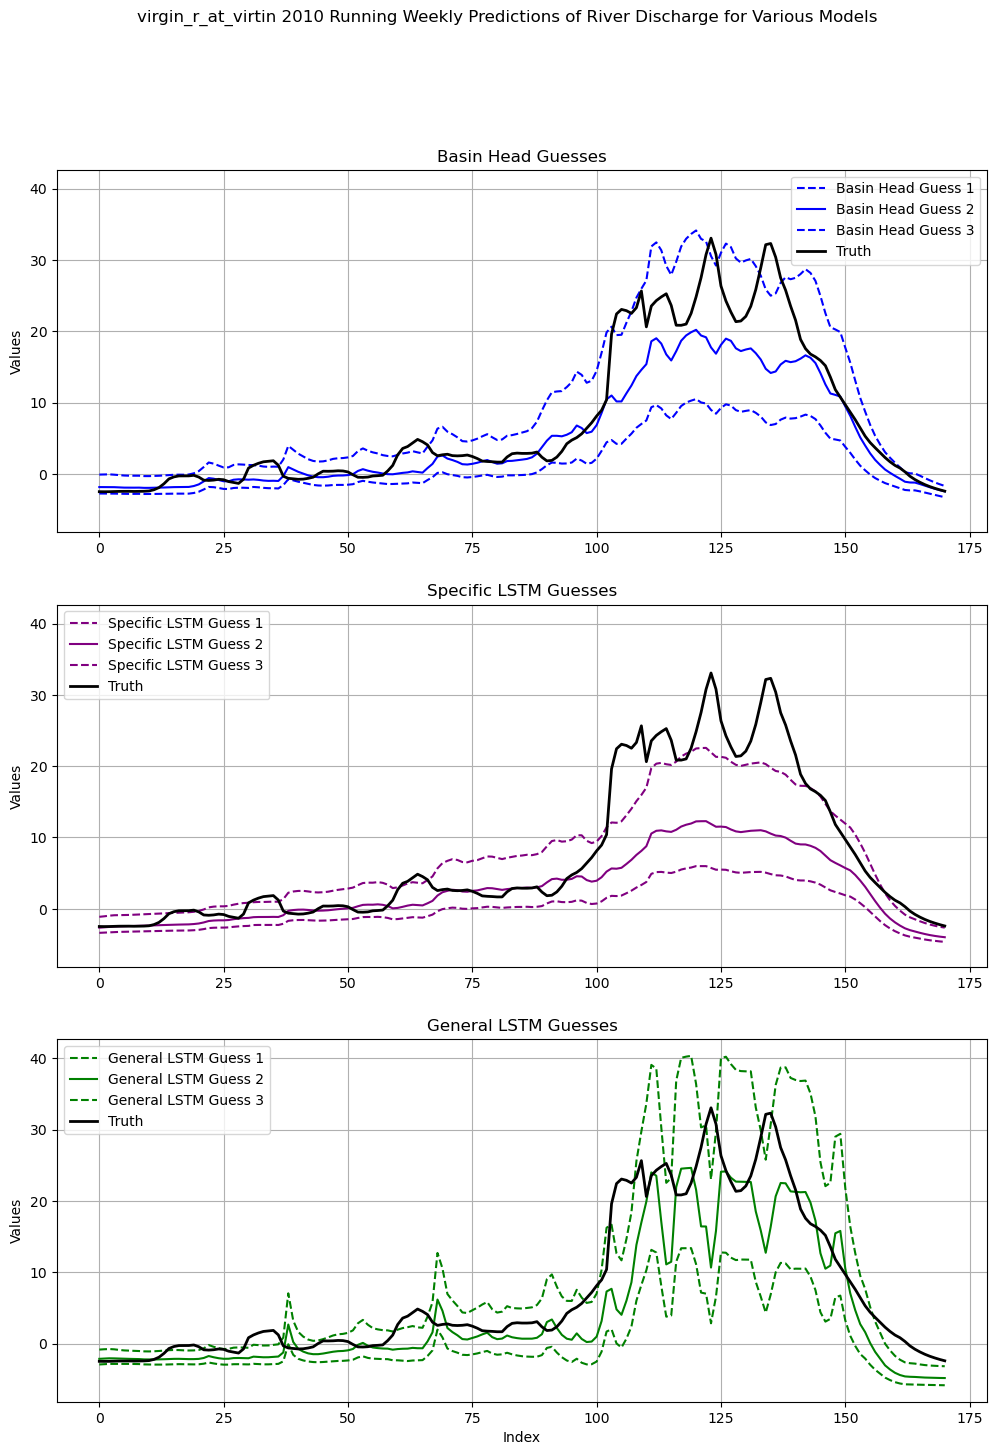

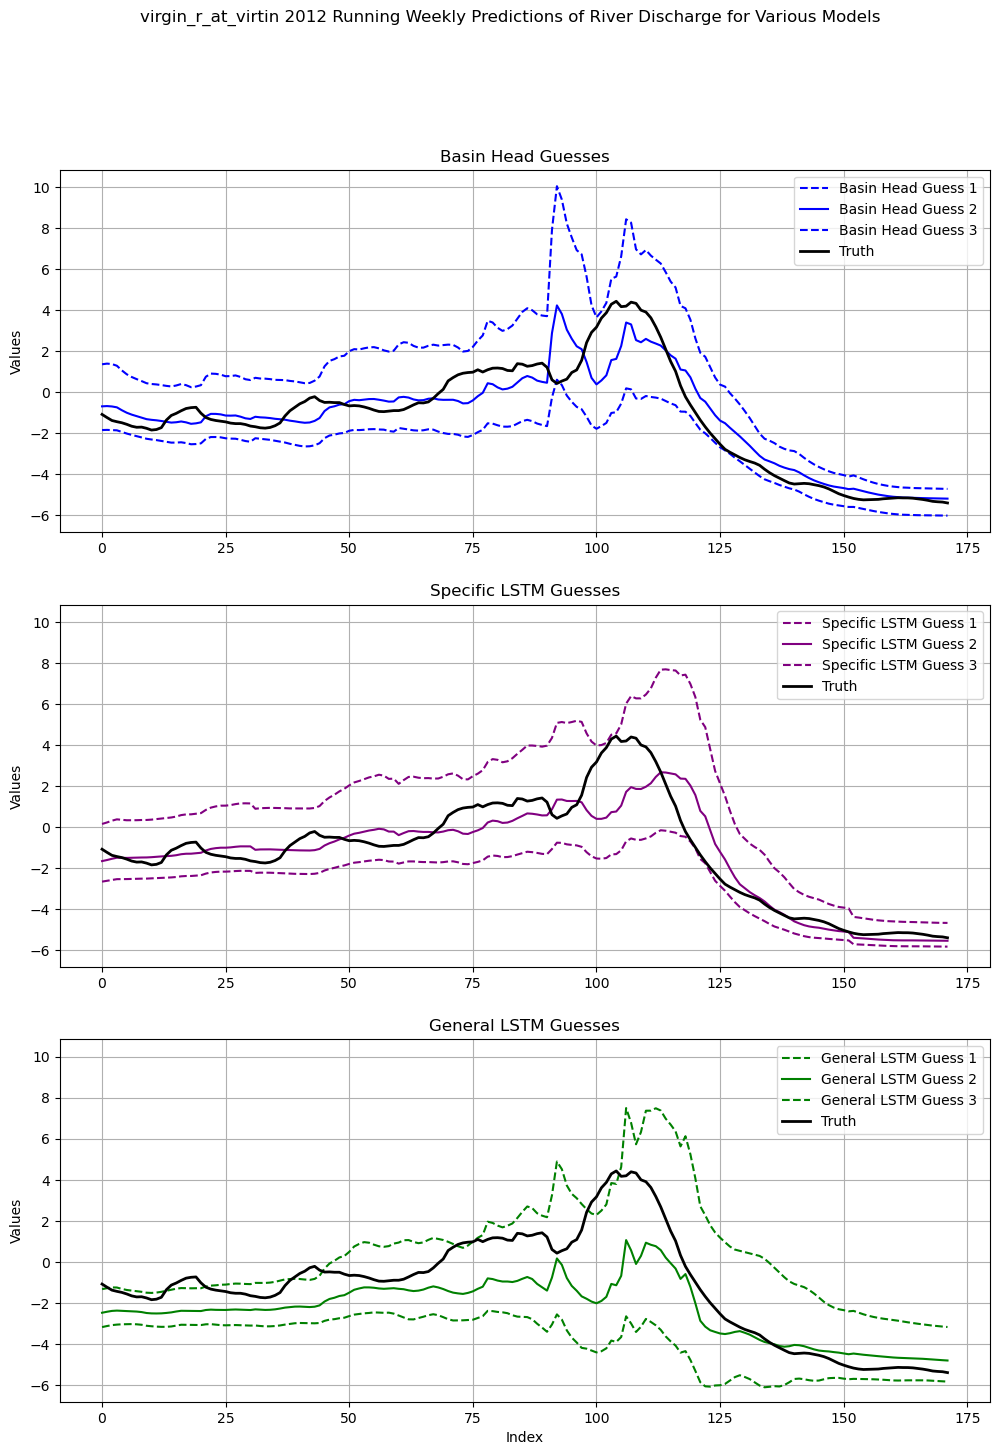

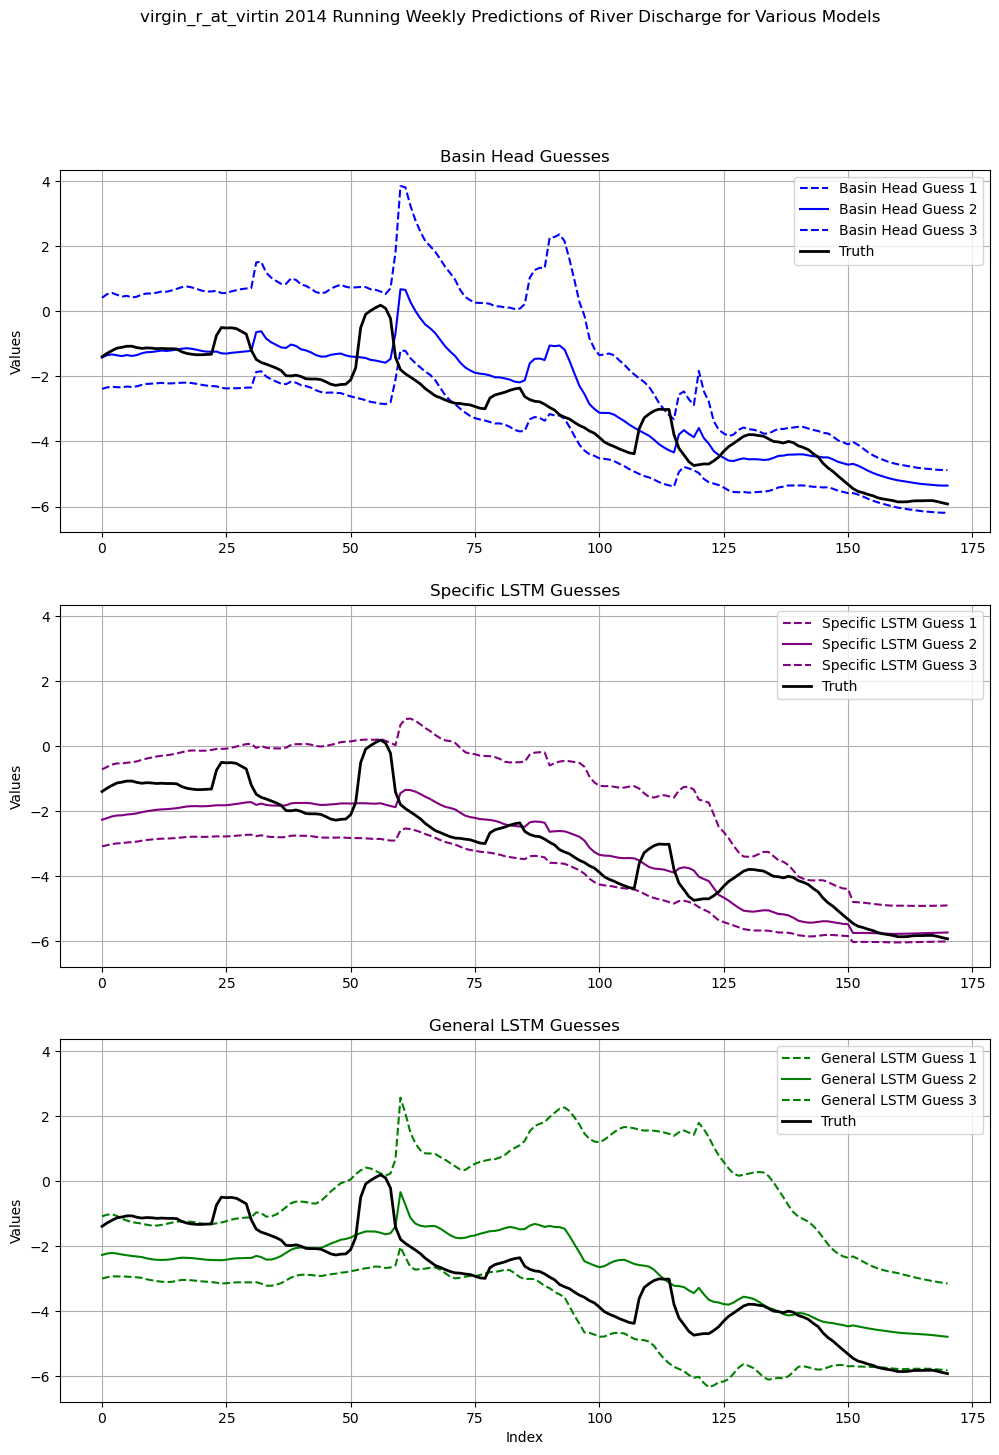

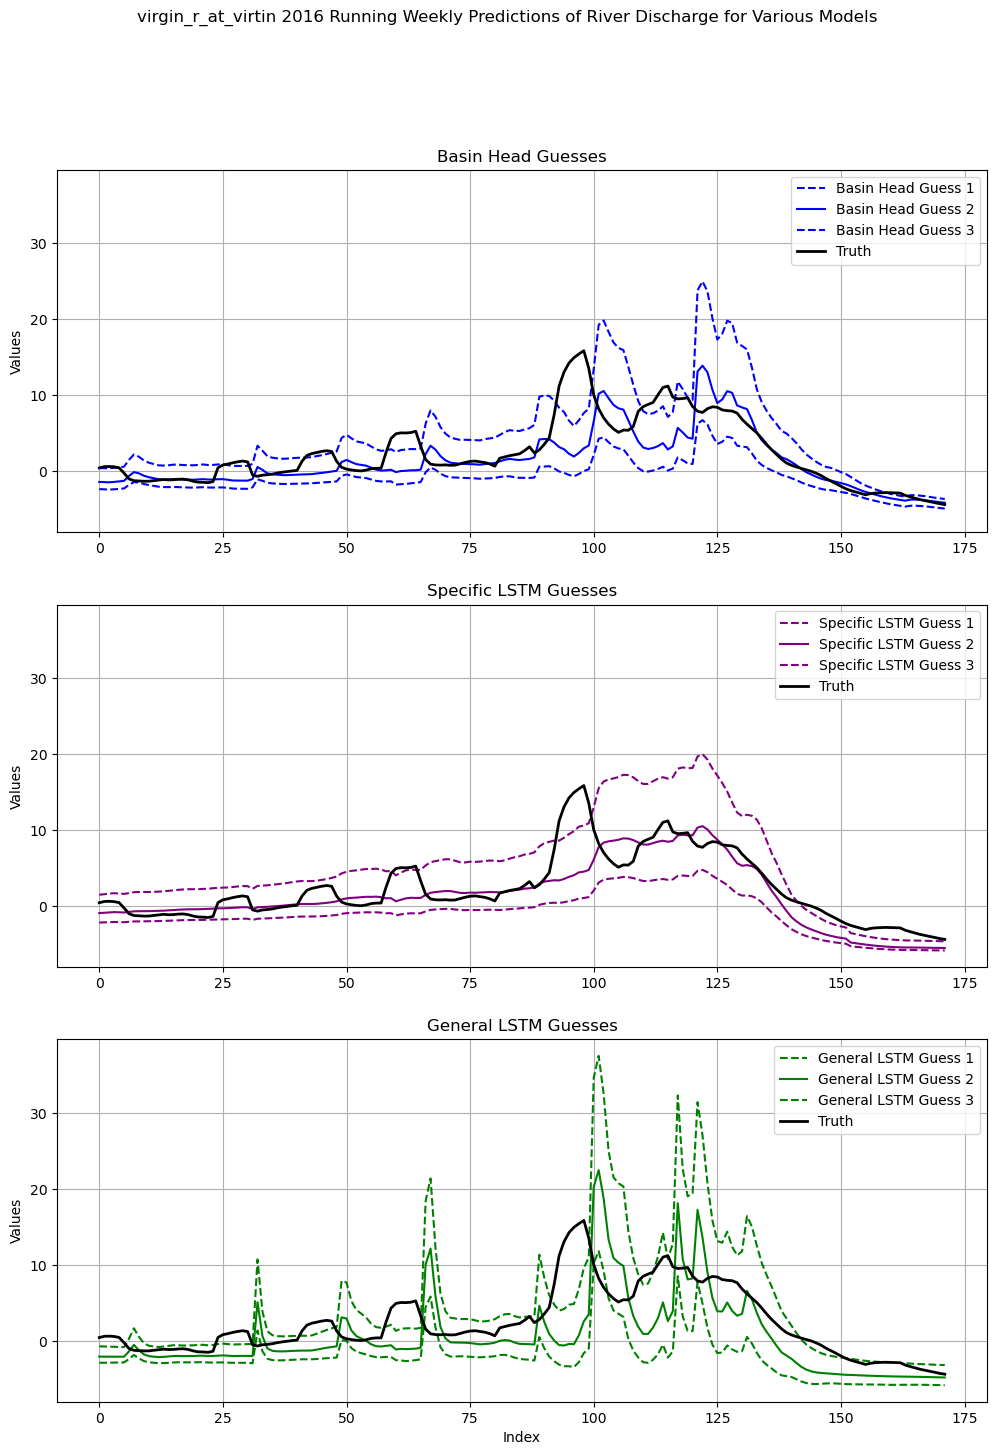

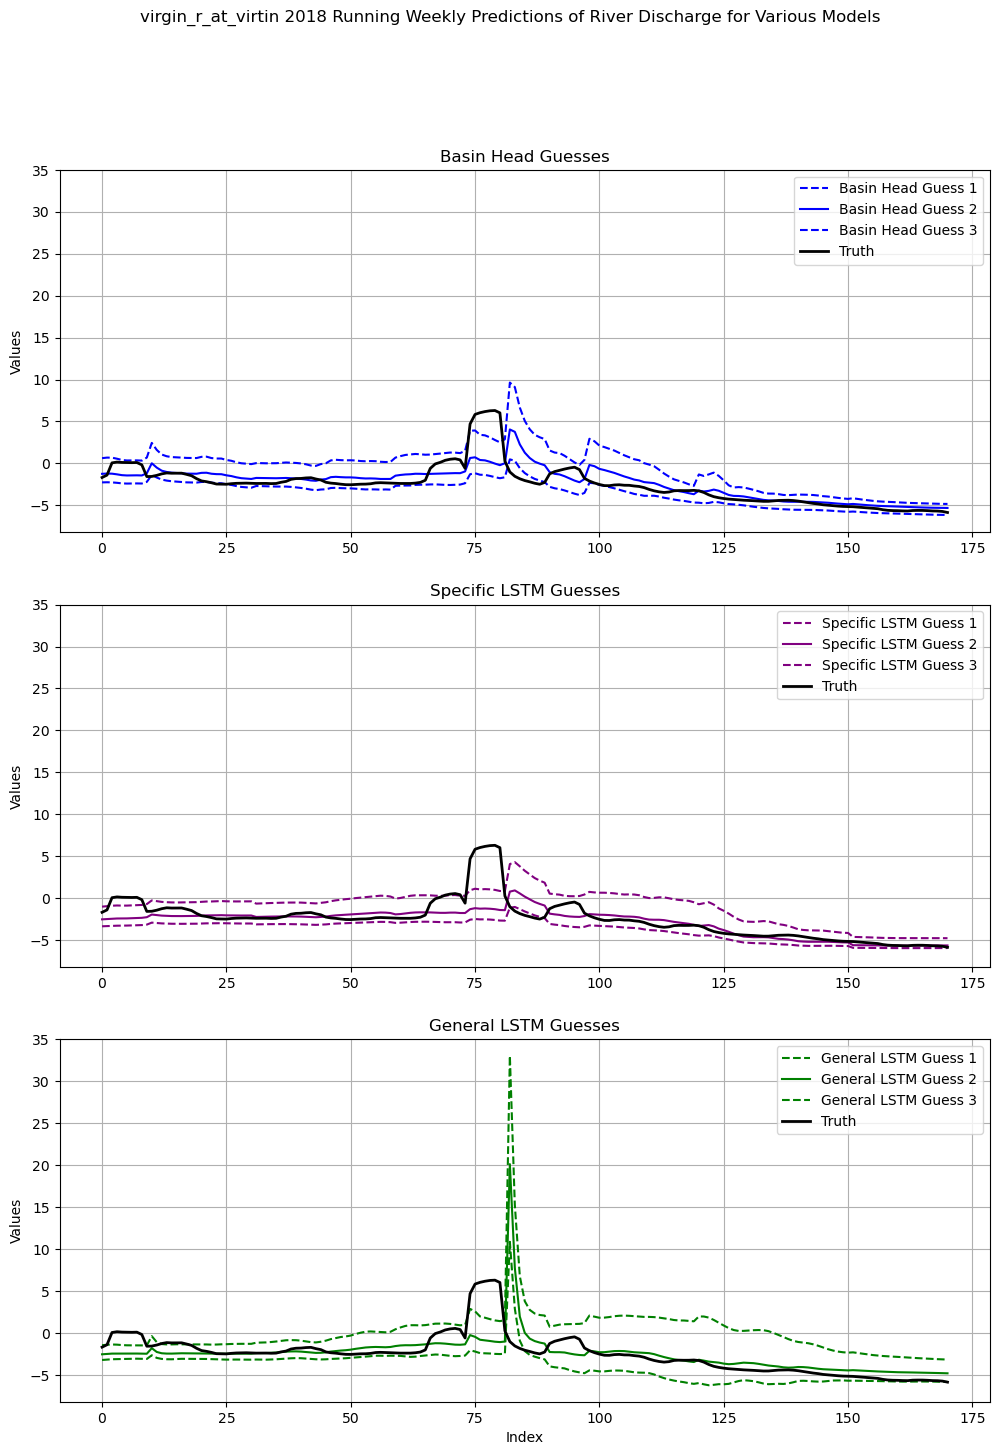

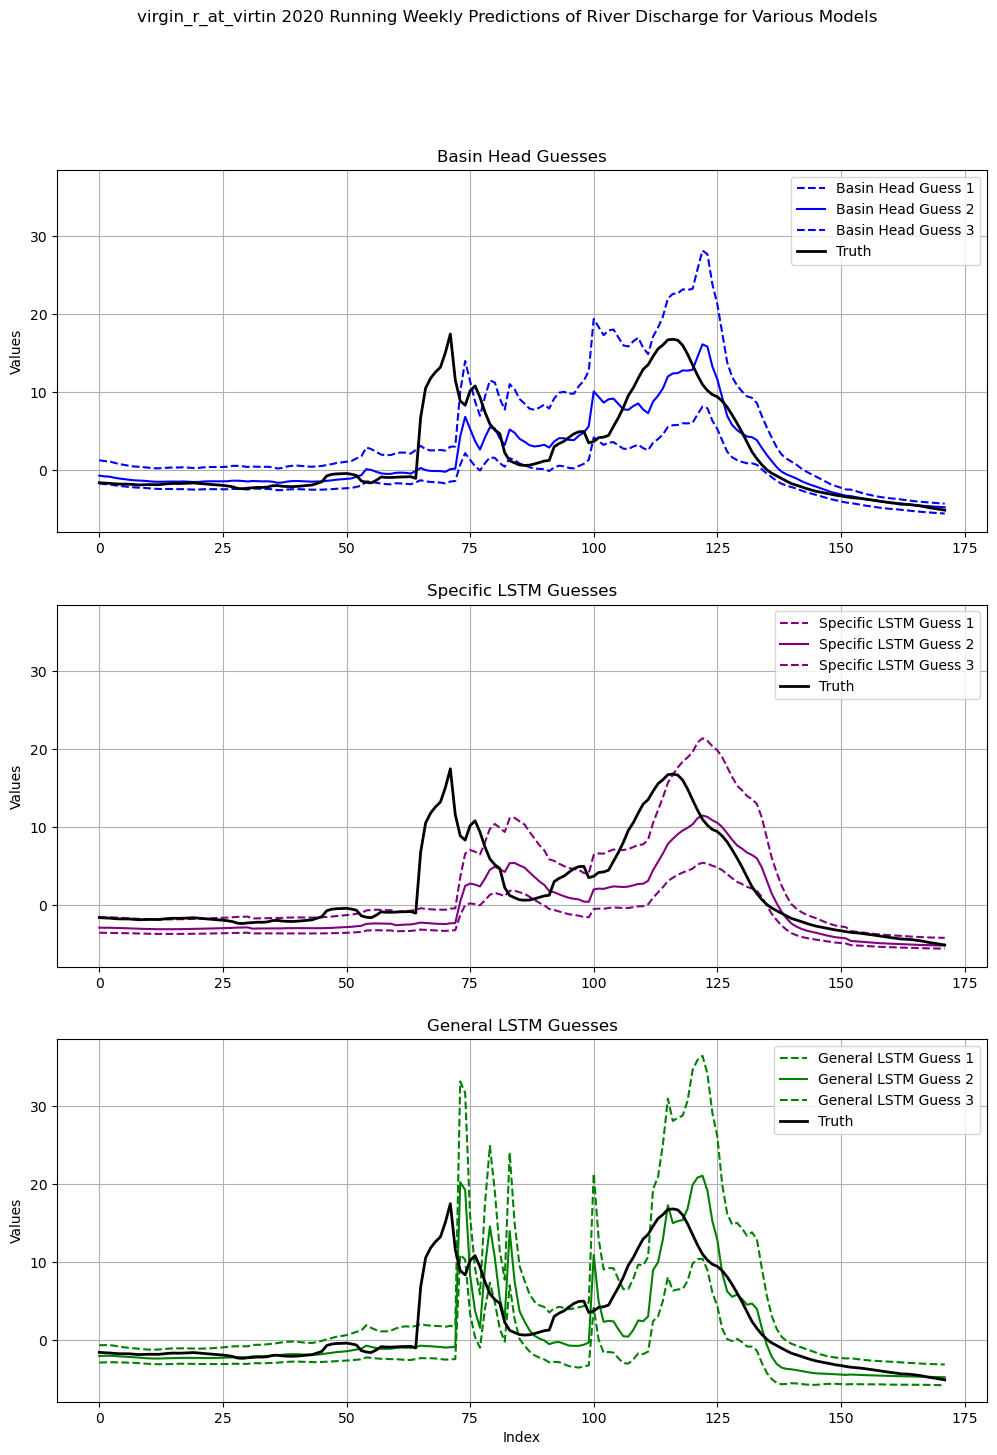

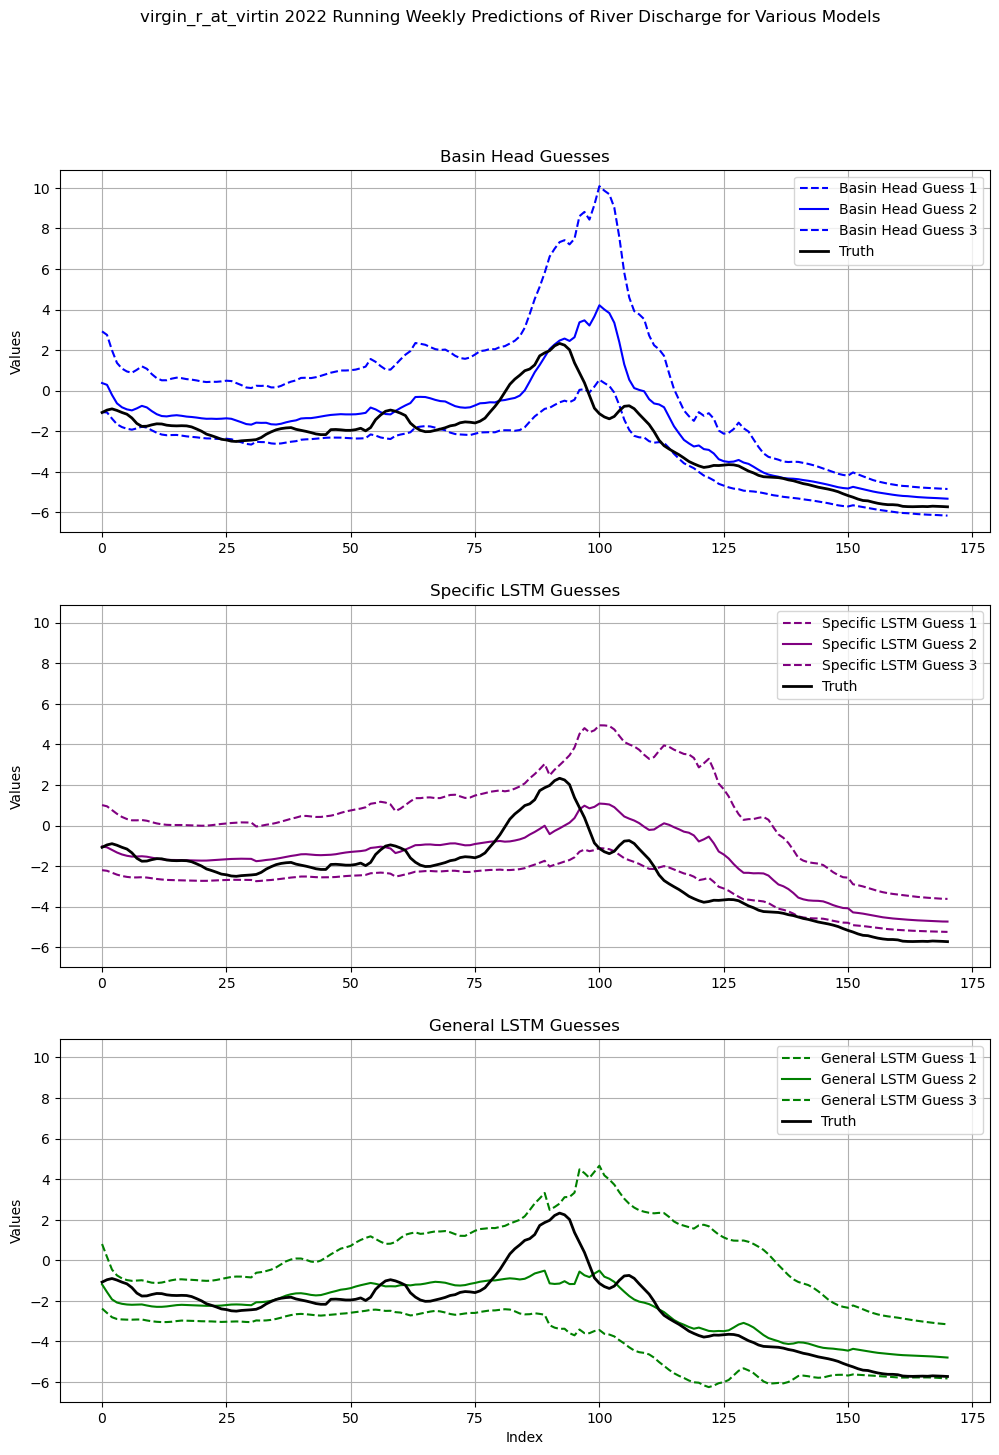

In [81]:
for year in years :
    start_season_date = f'{year}-01-01' 
    end_season_date = f'{year}-06-26'
    basin = 'virgin_r_at_virtin'
    Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False)
    _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = False)
    _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [7], feed_forcing = False, specialised = True)
    
    Days = len(Basin_Head_Guesses)
    Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
    General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
    Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

    General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
    Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)

    plot_predictions(Basin_Head_Guesses, Specific_LSTM_Guesses, General_LSTM_Guesses, Truth, f'{basin}', year)


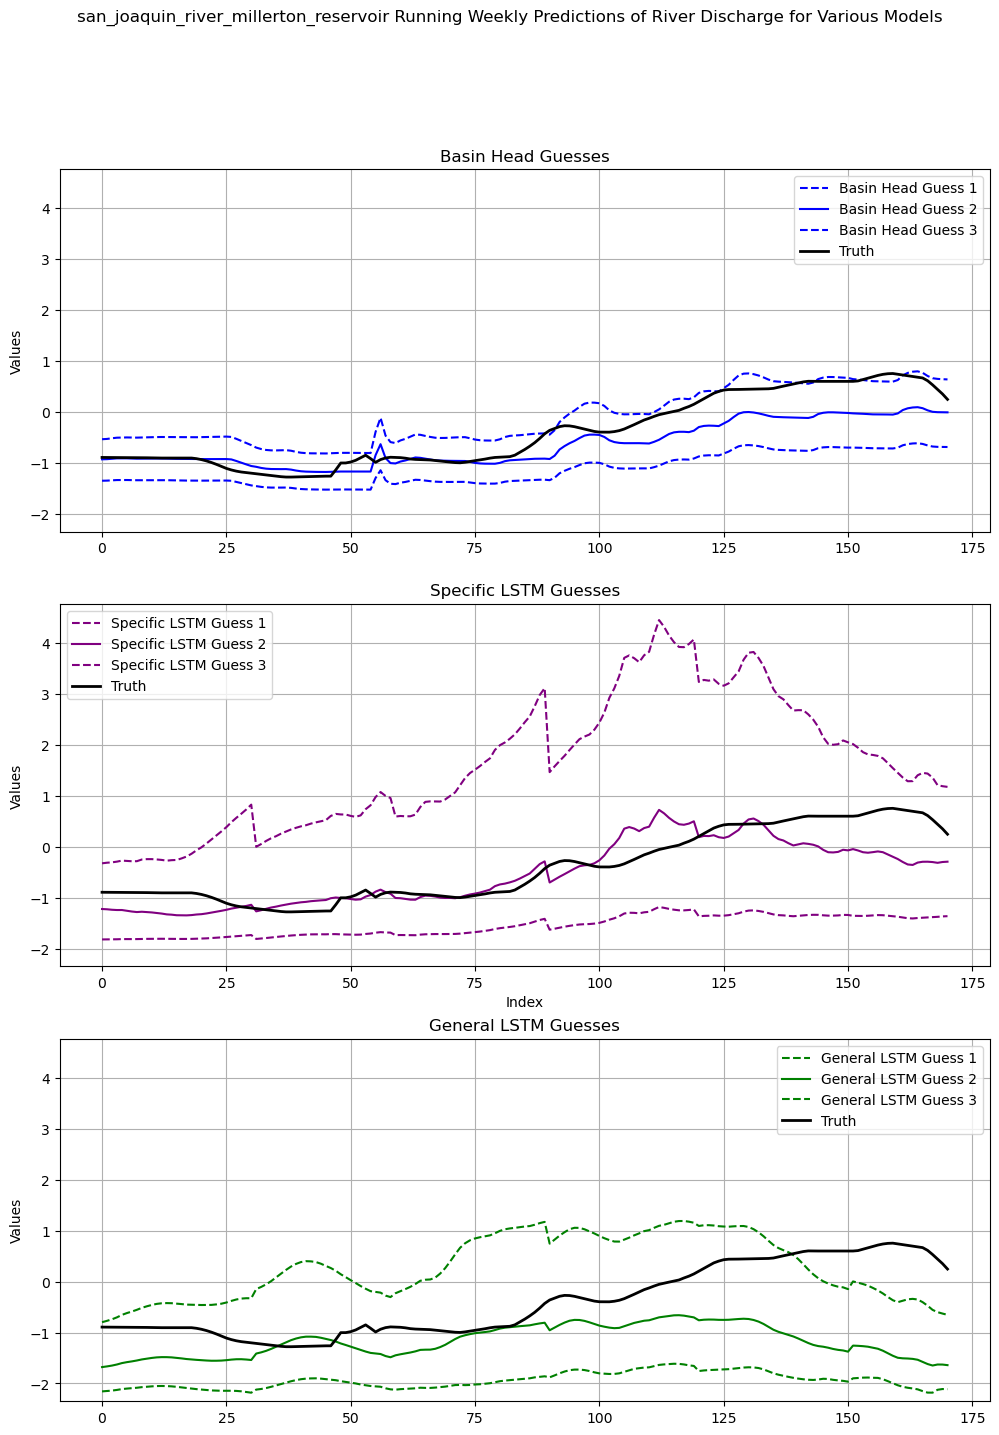

In [78]:
# Define the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex=False)

# Plot Basin Head Guesses
axs[0].plot(Basin_Head_Guesses[:, 0], color='blue', linestyle='--', label='Basin Head Guess 1')
axs[0].plot(Basin_Head_Guesses[:, 1], color='blue', linestyle='-', label='Basin Head Guess 2')
axs[0].plot(Basin_Head_Guesses[:, 2], color='blue', linestyle='--', label='Basin Head Guess 3')
axs[0].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
axs[0].set_ylabel('Values')
axs[0].set_title('Basin Head Guesses')
axs[0].legend()
axs[0].grid(True)

# Plot Specific Model Guesses
axs[1].plot(Specific_LSTM_Guesses[:, 0], color='purple', linestyle='--', label='Specific LSTM Guess 1')
axs[1].plot(Specific_LSTM_Guesses[:, 1], color='purple', linestyle='-', label='Specific LSTM Guess 2')
axs[1].plot(Specific_LSTM_Guesses[:, 2], color='purple', linestyle='--', label='Specific LSTM Guess 3')
axs[1].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
axs[1].set_ylabel('Values')
axs[1].set_title('Specific LSTM Guesses')
axs[1].set_xlabel('Index')
axs[1].legend()
axs[1].grid(True)

# Plot General LSTM Guesses
axs[2].plot(General_LSTM_Guesses[:, 0], color='green', linestyle='--', label='General LSTM Guess 1')
axs[2].plot(General_LSTM_Guesses[:, 1], color='green', linestyle='-', label='General LSTM Guess 2')
axs[2].plot(General_LSTM_Guesses[:, 2], color='green', linestyle='--', label='General LSTM Guess 3')
axs[2].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
axs[2].set_ylabel('Values')
axs[2].set_title('General LSTM Guesses')
axs[2].legend()
axs[2].grid(True)


# # Plot General Head Guesses
# axs[3].plot(General_Head_Guesses[:, 0], color='orange', linestyle='--', label='General Head Guess 1')
# axs[3].plot(General_Head_Guesses[:, 1], color='orange', linestyle='-', label='General Head Guess 2')
# axs[3].plot(General_Head_Guesses[:, 2], color='orange', linestyle='--', label='General Head Guess 3')
# axs[3].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
# axs[3].set_ylabel('Values')
# axs[3].set_title('General Head Guesses')
# axs[3].legend()
# axs[3].grid(True)


# Set the same y-limits for all subplots
y_limits = [
    axs[0].get_ylim(),
    axs[1].get_ylim(),
    axs[2].get_ylim(),
    #axs[3].get_ylim(),
]

common_y_limits = (min([lim[0] for lim in y_limits]), max([lim[1] for lim in y_limits]))

for ax in axs:
    ax.set_ylim(common_y_limits)
    
# Customize the plot
plt.suptitle(f'{basin} Running Weekly Predictions of River Discharge for Various Models')

# Show the plot
plt.show()

In [76]:

def plot_predictions(Basin_Head_Guesses, Specific_LSTM_Guesses, General_LSTM_Guesses, Truth, basin, year):
    fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex=False)

    # Plot Basin Head Guesses
    axs[0].plot(Basin_Head_Guesses[:, 0], color='blue', linestyle='--', label='Basin Head Guess 1')
    axs[0].plot(Basin_Head_Guesses[:, 1], color='blue', linestyle='-', label='Basin Head Guess 2')
    axs[0].plot(Basin_Head_Guesses[:, 2], color='blue', linestyle='--', label='Basin Head Guess 3')
    axs[0].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[0].set_ylabel('Values')
    axs[0].set_title('Basin Head Guesses')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Specific Model Guesses
    axs[1].plot(Specific_LSTM_Guesses[:, 0], color='purple', linestyle='--', label='Specific LSTM Guess 1')
    axs[1].plot(Specific_LSTM_Guesses[:, 1], color='purple', linestyle='-', label='Specific LSTM Guess 2')
    axs[1].plot(Specific_LSTM_Guesses[:, 2], color='purple', linestyle='--', label='Specific LSTM Guess 3')
    axs[1].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[1].set_ylabel('Values')
    axs[1].set_title('Specific LSTM Guesses')
    axs[1].legend()
    axs[1].grid(True)

    # Plot General LSTM Guesses
    axs[2].plot(General_LSTM_Guesses[:, 0], color='green', linestyle='--', label='General LSTM Guess 1')
    axs[2].plot(General_LSTM_Guesses[:, 1], color='green', linestyle='-', label='General LSTM Guess 2')
    axs[2].plot(General_LSTM_Guesses[:, 2], color='green', linestyle='--', label='General LSTM Guess 3')
    axs[2].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[2].set_ylabel('Values')
    axs[2].set_title('General LSTM Guesses')
    axs[2].set_xlabel('Index')
    axs[2].legend()
    axs[2].grid(True)

    # Set the same y-limits for all subplots
    y_limits = [
        axs[0].get_ylim(),
        axs[1].get_ylim(),
        axs[2].get_ylim(),
    ]

    common_y_limits = (min([lim[0] for lim in y_limits]), max([lim[1] for lim in y_limits]))

    for ax in axs:
        ax.set_ylim(common_y_limits)

    # Customize the plot
    plt.suptitle(f'{basin} {year} Running Weekly Predictions of River Discharge for Various Models')

    # Show the plot
    plt.show()

# Example usage (assuming you have the data arrays):


In [ ]:
# Plot the data
plt.figure(figsize=(12, 8))

# Plot Basin Head Guesses
plt.plot(Basin_Head_Guesses[:, 0], color='blue', linestyle='--', label='Basin Head Guess 1')
plt.plot(Basin_Head_Guesses[:, 1], color='blue', linestyle='-', label='Basin Head Guess 2')
plt.plot(Basin_Head_Guesses[:, 2], color='blue', linestyle='--', label='Basin Head Guess 3')

# # Plot General Head Guesses
# plt.plot(General_Head_Guesses[:, 0], color='orange', linestyle='--', label='General Head Guess 1')
# plt.plot(General_Head_Guesses[:, 1], color='orange', linestyle='-', label='General Head Guess 2')
# plt.plot(General_Head_Guesses[:, 2], color='orange', linestyle='--', label='General Head Guess 3')

# # Plot General Guesses
# plt.plot(General_LSTM_Guesses[:, 0], color='cyan', linestyle='--', label='General LSTM Guess 1')
# plt.plot(General_LSTM_Guesses[:, 1], color='cyan', linestyle='-', label='General LSTM Guess 2')
# plt.plot(General_LSTM_Guesses[:, 2], color='cyan', linestyle='--', label='General LSTM Guess 3')

# Plot Specific Model Guesses
plt.plot(Specific_LSTM_Guesses[:, 0], color='purple', linestyle='--', label='Specific LSTM Guess 1')
plt.plot(Specific_LSTM_Guesses[:, 1], color='purple', linestyle='-', label='Specific LSTM Guess 2')
plt.plot(Specific_LSTM_Guesses[:, 2], color='purple', linestyle='--', label='Specific LSTM Guess 3')



# Plot Truth
plt.plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')

    # Customize the plot
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Running Weekly Predictions of River Dishcarge for Various Models')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:

# Plot Climatology Guesses
# plt.plot(Climatology_Guesses[:, 0], color='grey', linestyle='--', label='Climatology Guess 1')
# plt.plot(Climatology_Guesses[:, 1], color='grey', linestyle='-', label='Climatology Guess 2')
# plt.plot(Climatology_Guesses[:, 2], color='grey', linestyle='--', label='Climatology Guess 3')



In [ ]:

flow_scaler_filename = f'/data/Hydra_Work/Rodeo_Data/scalers/flows/{basin}_flow_scaler.save'
flow_scaler = joblib.load(flow_scaler_filename) 

Specific, General, Truth, Climatology_10, Climatology_50, Climatology_90  = test_performance_for_basin_and_season(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, Static_variables, device, end_season_date, start_season_date, flow_scaler, furthest_distance=120, feed_forcing= feed_forcing)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Specific
No_Days = len(Specific[:, 0])
Days_Til_Season = No_Days - np.arange(1, No_Days + 1)

axes[0].plot(Truth, label='Truth')
axes[0].plot(Days_Til_Season, Specific[:, 0], label='10 Percentile Specific')
axes[0].plot(Days_Til_Season, Specific[:, 1], label='50 Percentile Specific')
axes[0].plot(Days_Til_Season, Specific[:, 2], label='90 Percentile Specific')
# axes[0].plot(Days_Til_Season, Climatology_10, label='10 Percentile Climatology')
# axes[0].plot(Days_Til_Season, Climatology_50, label='50 Percentile Climatology')
# axes[0].plot(Days_Til_Season, Climatology_90, label='90 Percentile Climatology')

axes[0].legend()
axes[0].set_title('Specific Percentiles')

# Plot for General
axes[1].plot(Truth, label='Truth')
axes[1].plot(Days_Til_Season, General[:, 0], label='10 Percentile General')
axes[1].plot(Days_Til_Season, General[:, 1], label='50 Percentile General')
axes[1].plot(Days_Til_Season, General[:, 2], label='90 Percentile General')


axes[1].legend()
axes[1].set_title('General Percentiles')

for ax in axes:
    ax.set_ylabel('Seasonal Discharge ($m^3/s$)')
    ax.invert_xaxis()
    ax.set_xlabel('Days Till End of Forecast')



plt.suptitle(f'Model performance at {basin}', fontsize=16)

Clmiatology = True
# Need to make code to get climatology of the season of interest
if Clmiatology == True:
    # Add horizontal dashed lines for quantiles
    axes[0].plot(Days_Til_Season, Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
    axes[0].plot(Days_Til_Season, Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
    axes[0].plot(Days_Til_Season, Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')

    axes[1].plot(Days_Til_Season,Climatology_10, linestyle='dashed', color='gray', label=f'10 Climatology')
    axes[1].plot(Days_Til_Season,Climatology_50, linestyle='dashed', color='gray', label=f'50 Climatology')
    axes[1].plot(Days_Til_Season,Climatology_90, linestyle='dashed', color='gray', label=f'90 Climatology')
    
plt.tight_layout()
plt.show()
